In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import model_selection
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier,DecisionTreeRegressor, plot_tree
from sklearn.tree import export_graphviz
import graphviz

from sklearn.preprocessing import LabelEncoder,MinMaxScaler, StandardScaler
from sklearn import preprocessing

import gc
import xgboost as xgb
RANDOM_STATE=42

In [2]:
# reduces the memory of a dataframe
def reduce_mem_usage(df, verbose = True):
    
    '''
    Reduces the space that a DataFrame occupies in memory.

    This function iterates over all columns in a df and downcasts them to lower type to save memory.
    '''
    
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose:
        print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'\
              .format(end_mem, 100 * (start_mem - end_mem) / start_mem))

## Agrupamos por Meses:

In [3]:
# Catgamos el dataset de train:
trans_file='transaccion_train.csv'
trans=pd.read_csv(trans_file)
trans.drop('Unnamed: 0',axis=1,inplace=True)

# Ponemos Periodo en fecha
trans['Periodo']=pd.to_datetime(trans['Periodo'],format='%Y%m')
trans['SignoNum']=1
trans.loc[ trans['Signo']=='Negativo', 'SignoNum']=-1
trans['MontoSigno']=trans['SignoNum']*trans['Monto']

In [4]:
trans

,id,Id_Producto,Tipo,Producto-Tipo,Signo,Monto,Fecha,Periodo,SignoNum,MontoSigno
0,1,F,D,F-D,Positivo,377142.843750,NaN,2019-01-01,1,377142.843750
1,1,F,D,F-D,Positivo,577142.875000,NaN,2019-03-01,1,577142.875000
2,1,F,D,F-D,Positivo,548571.437500,NaN,2019-04-01,1,548571.437500
3,1,F,D,F-D,Positivo,291428.562500,NaN,2019-05-01,1,291428.562500
4,1,F,D,F-D,Positivo,405714.281250,NaN,2019-06-01,1,405714.281250
...,...,...,...,...,...,...,...,...,...,...
24397532,79539,G,K,G-K,Negativo,196444.718750,NaN,2020-06-01,-1,-196444.718750
24397533,79539,G,K,G-K,Negativo,128644.289062,NaN,2020-06-01,-1,-128644.289062
24397534,79539,G,K,G-K,Negativo,124086.859375,NaN,2020-06-01,-1,-124086.859375
24397535,79539,A,G,A-G,NaN,185393.000000,2019-12-17,2019-12-01,1,185393.000000


In [5]:
trans['Periodo'].unique()

array(['2019-01-01T00:00:00.000000000', '2019-03-01T00:00:00.000000000',
       '2019-04-01T00:00:00.000000000', '2019-05-01T00:00:00.000000000',
       '2019-06-01T00:00:00.000000000', '2019-07-01T00:00:00.000000000',
       '2019-08-01T00:00:00.000000000', '2019-09-01T00:00:00.000000000',
       '2019-10-01T00:00:00.000000000', '2019-11-01T00:00:00.000000000',
       '2019-12-01T00:00:00.000000000', '2020-01-01T00:00:00.000000000',
       '2020-03-01T00:00:00.000000000', '2020-04-01T00:00:00.000000000',
       '2020-05-01T00:00:00.000000000', '2020-06-01T00:00:00.000000000',
       '2020-07-01T00:00:00.000000000', '2019-02-01T00:00:00.000000000',
       '2020-02-01T00:00:00.000000000'], dtype='datetime64[ns]')

In [16]:
trans['Periodo'].unique()[1:]

array(['2019-03-01T00:00:00.000000000', '2019-04-01T00:00:00.000000000',
       '2019-05-01T00:00:00.000000000', '2019-06-01T00:00:00.000000000',
       '2019-07-01T00:00:00.000000000', '2019-08-01T00:00:00.000000000',
       '2019-09-01T00:00:00.000000000', '2019-10-01T00:00:00.000000000',
       '2019-11-01T00:00:00.000000000', '2019-12-01T00:00:00.000000000',
       '2020-01-01T00:00:00.000000000', '2020-03-01T00:00:00.000000000',
       '2020-04-01T00:00:00.000000000', '2020-05-01T00:00:00.000000000',
       '2020-06-01T00:00:00.000000000', '2020-07-01T00:00:00.000000000',
       '2019-02-01T00:00:00.000000000', '2020-02-01T00:00:00.000000000'],
      dtype='datetime64[ns]')

## Agrupamos por trimestres

In [6]:
i=0
P=1
ano=2019
lista=[]
# Cojemos la lista de fechas pero quitamos el primer mes para que nos salgan bien los grupos de tres
for x in list(trans['Periodo'].unique()[1:]):
    #Agrupamos las fechas de tres en tres en una lista
    if (i < 3):
        lista.append(x)
        i=i+1
    else:
        lista=[]
        lista.append(x)
        i=1
    # Solo cuando la lista tiene tres elementos agrupamos
    if (i==3):
        #Creamos un dataset agrupado para esos tres meses
        trans_T=trans[trans['Periodo'].isin(lista)].pivot_table(index=['id','Producto-Tipo'],
                                                                  values=['MontoSigno'],
                                                                  aggfunc=[len,np.sum,np.mean,np.max,np.min]).reset_index(drop=False)
        #Creamos el Periodo Trimestral
        trans_T['Periodo']=P   
        if (P==1):
            trans_train=trans_T
        else :
            trans_train=pd.concat([trans_train,trans_T],axis=0)   
        P=P+1

In [7]:
# estudiamos el resultado de esta agrupacion
trans_train

,id,Producto-Tipo,len,sum,mean,amax,amin,Periodo
,,,MontoSigno,MontoSigno,MontoSigno,MontoSigno,MontoSigno,
0,1,A-G,4.0,1.015275e+06,253818.750000,281602.000000,229566.000000,1
1,1,A-K,76.0,-9.978991e+06,-131302.507607,-121428.570312,-173353.718750,1
2,1,F-D,3.0,1.417143e+06,472380.958333,577142.875000,291428.562500,1
3,1,F-H,3.0,-1.417143e+06,-472380.958333,-291428.562500,-577142.875000,1
4,1,F-J,3.0,1.417143e+06,472380.958333,577142.875000,291428.562500,1
...,...,...,...,...,...,...,...,...
559802,79538,G-K,5.0,-6.818283e+05,-136365.656250,-121485.570312,-187921.140625,6
559803,79539,C-C,2.0,-7.432836e+05,-371641.796875,-191787.281250,-551496.312500,6
559804,79539,C-D,2.0,5.120584e+05,256029.210938,320160.000000,191898.421875,6


In [8]:
trans_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3111888 entries, 0 to 559806
Data columns (total 8 columns):
 #   Column              Dtype  
---  ------              -----  
 0   (id, )              int64  
 1   (Producto-Tipo, )   object 
 2   (len, MontoSigno)   float64
 3   (sum, MontoSigno)   float64
 4   (mean, MontoSigno)  float64
 5   (amax, MontoSigno)  float64
 6   (amin, MontoSigno)  float64
 7   (Periodo, )         int64  
dtypes: float64(5), int64(2), object(1)
memory usage: 213.7+ MB


In [9]:
trans_train.columns=['id','Producto-Tipo',
                     'Count','MontoSignoSum','MontoSignoMean','MontoSignoMax','MontoSignoMin',
                     'Periodo']

In [10]:
trans_train['Periodo'].value_counts()

6    559807
4    549828
5    511278
3    507090
2    493835
1    490050
Name: Periodo, dtype: int64

In [12]:
trans_train['Periodo'].unique()

array([1, 2, 3, 4, 5, 6], dtype=int64)

In [13]:
map_periodos={1:'201904',
              2:'201907',
              3:'201910',
              4:'202001',
              5:'202004',
              6:'202007'}

In [14]:
trans_train['Periodo2']=trans_train['Periodo'].map(map_periodos)

In [17]:
trans_train

,id,Producto-Tipo,Count,MontoSignoSum,MontoSignoMean,MontoSignoMax,MontoSignoMin,Periodo,Periodo2
0,1,A-G,4.0,1.015275e+06,253818.750000,281602.000000,229566.000000,1,201904
1,1,A-K,76.0,-9.978991e+06,-131302.507607,-121428.570312,-173353.718750,1,201904
2,1,F-D,3.0,1.417143e+06,472380.958333,577142.875000,291428.562500,1,201904
3,1,F-H,3.0,-1.417143e+06,-472380.958333,-291428.562500,-577142.875000,1,201904
4,1,F-J,3.0,1.417143e+06,472380.958333,577142.875000,291428.562500,1,201904
...,...,...,...,...,...,...,...,...,...
559802,79538,G-K,5.0,-6.818283e+05,-136365.656250,-121485.570312,-187921.140625,6,202007
559803,79539,C-C,2.0,-7.432836e+05,-371641.796875,-191787.281250,-551496.312500,6,202007
559804,79539,C-D,2.0,5.120584e+05,256029.210938,320160.000000,191898.421875,6,202007
559805,79539,F-J,2.0,2.400000e+05,120000.000000,120000.000000,120000.000000,6,202007


In [18]:
# Ponemos Periodo en fecha
trans_train['Periodo2']=pd.to_datetime(trans_train['Periodo2'],format='%Y%m')

In [19]:
trans_train

,id,Producto-Tipo,Count,MontoSignoSum,MontoSignoMean,MontoSignoMax,MontoSignoMin,Periodo,Periodo2
0,1,A-G,4.0,1.015275e+06,253818.750000,281602.000000,229566.000000,1,2019-04-01
1,1,A-K,76.0,-9.978991e+06,-131302.507607,-121428.570312,-173353.718750,1,2019-04-01
2,1,F-D,3.0,1.417143e+06,472380.958333,577142.875000,291428.562500,1,2019-04-01
3,1,F-H,3.0,-1.417143e+06,-472380.958333,-291428.562500,-577142.875000,1,2019-04-01
4,1,F-J,3.0,1.417143e+06,472380.958333,577142.875000,291428.562500,1,2019-04-01
...,...,...,...,...,...,...,...,...,...
559802,79538,G-K,5.0,-6.818283e+05,-136365.656250,-121485.570312,-187921.140625,6,2020-07-01
559803,79539,C-C,2.0,-7.432836e+05,-371641.796875,-191787.281250,-551496.312500,6,2020-07-01
559804,79539,C-D,2.0,5.120584e+05,256029.210938,320160.000000,191898.421875,6,2020-07-01
559805,79539,F-J,2.0,2.400000e+05,120000.000000,120000.000000,120000.000000,6,2020-07-01


In [20]:
# Estudiamos un poco esto:
trans_train.groupby(['id','Producto-Tipo'])['Periodo2'].size()

id     Producto-Tipo
1      A-G              6
       A-K              6
       F-D              6
       F-H              6
       F-I              2
                       ..
79539  E-F              3
       F-H              3
       F-I              1
       F-J              6
       G-K              3
Name: Periodo2, Length: 766914, dtype: int64

## Hacemos los mismo con TEST. 


In [21]:
transacciones_file='Transaccion_test.csv'
trans_test_1=pd.read_csv(transacciones_file)
trans_test_1.drop('Unnamed: 0',axis=1, inplace=True)

In [22]:
# Ponemos Periodo en fecha
trans_test_1['Periodo']=pd.to_datetime(trans_test_1['Periodo'],format='%Y%m')
trans_test_1['SignoNum']=1
trans_test_1.loc[ trans_test_1['Signo']=='Negativo', 'SignoNum']=-1
trans_test_1['MontoSigno']=trans_test_1['SignoNum']*trans_test_1['Monto']

In [23]:
trans_test_1

,id,Id_Producto,Tipo,Producto-Tipo,Signo,Monto,Fecha,Periodo,SignoNum,MontoSigno
0,1,F,D,F-D,Positivo,405714.281250,NaN,2020-08-01,1,405714.281250
1,1,F,D,F-D,Positivo,591428.562500,NaN,2020-09-01,1,591428.562500
2,1,F,D,F-D,Positivo,405714.281250,NaN,2020-10-01,1,405714.281250
3,1,F,H,F-H,Negativo,405714.281250,NaN,2020-08-01,-1,-405714.281250
4,1,F,H,F-H,Negativo,591428.562500,NaN,2020-09-01,-1,-591428.562500
...,...,...,...,...,...,...,...,...,...,...
3743640,79539,G,K,G-K,Negativo,123282.859375,NaN,2020-10-01,-1,-123282.859375
3743641,79539,G,K,G-K,Negativo,122348.570312,NaN,2020-10-01,-1,-122348.570312
3743642,79539,G,K,G-K,Negativo,165910.421875,NaN,2020-10-01,-1,-165910.421875
3743643,79539,G,K,G-K,Negativo,121699.429688,NaN,2020-10-01,-1,-121699.429688


In [24]:
i=0
P=1
ano=2019
lista=[]
# Cojemos la lista de fechas pero quitamos el primer mes para que nos salgan bien los grupos de tres
for x in list(trans_test_1['Periodo'].unique()[0:-1]):
    #Agrupamos las fechas de tres en tres en una lista
    if (i < 3):
        lista.append(x)
        i=i+1
    else:
        lista=[]
        lista.append(x)
        i=1
    # Solo cuando la lista tiene tres elementos agrupamos
    if (i==3):
        #Creamos un dataset agrupado para esos tres meses
        trans_T=trans_test_1[trans_test_1['Periodo'].isin(lista)].pivot_table(index=['id','Producto-Tipo'],
                                                                  values=['MontoSigno'],
                                                                  aggfunc=[len,np.sum,np.mean,np.max,np.min]).reset_index(drop=False)
        #Creamos el Periodo Trimestral
        trans_T['Periodo']=P   
        if (P==1):
            trans_test=trans_T
        else :
            trans_test=pd.concat([trans_test,trans_T],axis=0)   
        P=P+1

In [25]:
trans_test

,id,Producto-Tipo,len,sum,mean,amax,amin,Periodo
,,,MontoSigno,MontoSigno,MontoSigno,MontoSigno,MontoSigno,
0,1,A-G,4.0,1.149213e+06,287303.250000,314994.000000,2.397200e+05,1
1,1,A-K,37.0,-4.900651e+06,-132450.034628,-120982.859375,-1.721187e+05,1
2,1,F-D,3.0,1.402857e+06,467619.041667,591428.562500,4.057143e+05,1
3,1,F-H,3.0,-1.402857e+06,-467619.041667,-405714.281250,-5.914286e+05,1
4,1,F-I,3.0,-1.402857e+06,-467619.041667,-405714.281250,-5.914286e+05,1
...,...,...,...,...,...,...,...,...
491532,79539,C-C,3.0,-2.163058e+06,-721019.406250,-263033.843750,-1.579864e+06,1
491533,79539,E-F,1.0,-1.207140e+05,-120714.000000,-120714.000000,-1.207140e+05,1
491534,79539,F-H,2.0,-2.400000e+05,-120000.000000,-120000.000000,-1.200000e+05,1


In [26]:
trans_test.columns=['id','Producto-Tipo',
                     'Count','MontoSignoSum','MontoSignoMean','MontoSignoMax','MontoSignoMin',
                     'Periodo']

In [27]:
trans_test['Periodo'].value_counts()

1    491537
Name: Periodo, dtype: int64

In [30]:
trans_test['Periodo'].unique()

array([1], dtype=int64)

In [31]:
map_periodos={1:'202010'}

In [32]:
trans_test['Periodo2']=trans_test['Periodo'].map(map_periodos)

In [33]:
# Ponemos Periodo en fecha
trans_test['Periodo2']=pd.to_datetime(trans_test['Periodo2'],format='%Y%m')

In [34]:
trans_test 

,id,Producto-Tipo,Count,MontoSignoSum,MontoSignoMean,MontoSignoMax,MontoSignoMin,Periodo,Periodo2
0,1,A-G,4.0,1.149213e+06,287303.250000,314994.000000,2.397200e+05,1,2020-10-01
1,1,A-K,37.0,-4.900651e+06,-132450.034628,-120982.859375,-1.721187e+05,1,2020-10-01
2,1,F-D,3.0,1.402857e+06,467619.041667,591428.562500,4.057143e+05,1,2020-10-01
3,1,F-H,3.0,-1.402857e+06,-467619.041667,-405714.281250,-5.914286e+05,1,2020-10-01
4,1,F-I,3.0,-1.402857e+06,-467619.041667,-405714.281250,-5.914286e+05,1,2020-10-01
...,...,...,...,...,...,...,...,...,...
491532,79539,C-C,3.0,-2.163058e+06,-721019.406250,-263033.843750,-1.579864e+06,1,2020-10-01
491533,79539,E-F,1.0,-1.207140e+05,-120714.000000,-120714.000000,-1.207140e+05,1,2020-10-01
491534,79539,F-H,2.0,-2.400000e+05,-120000.000000,-120000.000000,-1.200000e+05,1,2020-10-01
491535,79539,F-J,3.0,3.600000e+05,120000.000000,120000.000000,1.200000e+05,1,2020-10-01


In [35]:
# Estudiamos un poco esto:
trans_test.groupby(['id','Producto-Tipo'])['Periodo2'].size()

id     Producto-Tipo
1      A-G              1
       A-K              1
       F-D              1
       F-H              1
       F-I              1
                       ..
79539  C-C              1
       E-F              1
       F-H              1
       F-J              1
       G-K              1
Name: Periodo2, Length: 491537, dtype: int64

In [36]:
trans_train.to_pickle('./3T/trans_train.pkl', compression='zip')

In [37]:
trans_test.to_pickle('./3T/trans_test.pkl', compression='zip')

## Hacemos producto cartesiano en los dos:

## Para Train

In [38]:
trans_train.columns

Index(['id', 'Producto-Tipo', 'Count', 'MontoSignoSum', 'MontoSignoMean',
       'MontoSignoMax', 'MontoSignoMin', 'Periodo', 'Periodo2'],
      dtype='object')

In [39]:
trans_train.drop('Periodo',axis=1, inplace=True)

In [40]:
trans_train.columns=['id','Producto-Tipo',
                     'Count','MontoSignoSum','MontoSignoMean','MontoSignoMax','MontoSignoMin',
                     'Periodo']

In [41]:
trans_train.head()

,id,Producto-Tipo,Count,MontoSignoSum,MontoSignoMean,MontoSignoMax,MontoSignoMin,Periodo
0,1,A-G,4.0,1.015275e+06,253818.750000,281602.000000,229566.00000,2019-04-01
1,1,A-K,76.0,-9.978991e+06,-131302.507607,-121428.570312,-173353.71875,2019-04-01
2,1,F-D,3.0,1.417143e+06,472380.958333,577142.875000,291428.56250,2019-04-01
3,1,F-H,3.0,-1.417143e+06,-472380.958333,-291428.562500,-577142.87500,2019-04-01
4,1,F-J,3.0,1.417143e+06,472380.958333,577142.875000,291428.56250,2019-04-01


In [42]:
trans_train['Periodo'].unique()

array(['2019-04-01T00:00:00.000000000', '2019-07-01T00:00:00.000000000',
       '2019-10-01T00:00:00.000000000', '2020-01-01T00:00:00.000000000',
       '2020-04-01T00:00:00.000000000', '2020-07-01T00:00:00.000000000'],
      dtype='datetime64[ns]')

In [43]:
# Las fechas van de:  (Enero 2019 a Julio 2020)
lista_fechas=['2019-04-01',
'2019-07-01',
'2019-10-01',
'2020-01-01',
'2020-04-01',
'2020-07-01']      

In [44]:
lista_fechas

['2019-04-01',
 '2019-07-01',
 '2019-10-01',
 '2020-01-01',
 '2020-04-01',
 '2020-07-01']

In [45]:
trans_train['id'].value_counts()

68375    81
1316     80
70625    78
67755    78
67586    76
         ..
13519     1
45625     1
36015     1
29068     1
46871     1
Name: id, Length: 79539, dtype: int64

In [46]:
lista_clientes=trans_train['id'].unique().tolist()

In [60]:
lista_clientes

[1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,
 185

In [47]:
trans_train['Producto-Tipo'].value_counts(dropna=False)

F-J    431549
A-G    418469
A-K    396463
G-K    368424
F-H    329751
F-I    323312
F-D    170201
D-E    118230
D-F    114902
C-D     89135
C-C     87293
A-L     76267
E-F     66611
B-B     55057
E-E     51959
A-A     14265
Name: Producto-Tipo, dtype: int64

In [48]:
lista_productos=trans_train['Producto-Tipo'].unique().tolist()

In [49]:
lista_productos

['A-G',
 'A-K',
 'F-D',
 'F-H',
 'F-J',
 'G-K',
 'D-E',
 'D-F',
 'F-I',
 'E-E',
 'E-F',
 'A-L',
 'B-B',
 'A-A',
 'C-C',
 'C-D']

In [50]:
len(lista_fechas), len(lista_clientes), len(lista_productos)

(6, 79539, 16)

In [51]:
print('Filas totales: '+ str(len(lista_fechas)*len(lista_clientes)*len(lista_productos)) )

Filas totales: 7635744


In [52]:
cartesian_product = pd.MultiIndex.from_product([lista_clientes,lista_fechas, lista_productos ], 
                                               names = ['id','Periodo','Producto-Tipo'])
len(cartesian_product)

7635744

In [53]:
cartesian_product

MultiIndex([(    1, '2019-04-01', 'A-G'),
            (    1, '2019-04-01', 'A-K'),
            (    1, '2019-04-01', 'F-D'),
            (    1, '2019-04-01', 'F-H'),
            (    1, '2019-04-01', 'F-J'),
            (    1, '2019-04-01', 'G-K'),
            (    1, '2019-04-01', 'D-E'),
            (    1, '2019-04-01', 'D-F'),
            (    1, '2019-04-01', 'F-I'),
            (    1, '2019-04-01', 'E-E'),
            ...
            (60377, '2020-07-01', 'D-E'),
            (60377, '2020-07-01', 'D-F'),
            (60377, '2020-07-01', 'F-I'),
            (60377, '2020-07-01', 'E-E'),
            (60377, '2020-07-01', 'E-F'),
            (60377, '2020-07-01', 'A-L'),
            (60377, '2020-07-01', 'B-B'),
            (60377, '2020-07-01', 'A-A'),
            (60377, '2020-07-01', 'C-C'),
            (60377, '2020-07-01', 'C-D')],
           names=['id', 'Periodo', 'Producto-Tipo'], length=7635744)

In [54]:
full_df = pd.DataFrame(index = cartesian_product).reset_index()
full_df.tail()

,id,Periodo,Producto-Tipo
7635739,60377,2020-07-01,A-L
7635740,60377,2020-07-01,B-B
7635741,60377,2020-07-01,A-A
7635742,60377,2020-07-01,C-C
7635743,60377,2020-07-01,C-D


In [55]:
full_df['Periodo']=pd.to_datetime(full_df['Periodo'], format='%Y-%m-%d')

In [56]:
full_df.tail()

,id,Periodo,Producto-Tipo
7635739,60377,2020-07-01,A-L
7635740,60377,2020-07-01,B-B
7635741,60377,2020-07-01,A-A
7635742,60377,2020-07-01,C-C
7635743,60377,2020-07-01,C-D


In [57]:
full_df.groupby(['id','Periodo']).agg({'Producto-Tipo':len})

Producto-Tipo
id    Periodo                  
1     2019-04-01             16
      2019-07-01             16
      2019-10-01             16
      2020-01-01             16
      2020-04-01             16
...                         ...
79539 2019-07-01             16
      2019-10-01             16
      2020-01-01             16
      2020-04-01             16
      2020-07-01             16

[477234 rows x 1 columns]

In [85]:
full_df.groupby(['id','Periodo'])['Producto-Tipo'].size()

id     Periodo   
1      2019-04-01    16
       2019-07-01    16
       2019-10-01    16
       2020-01-01    16
       2020-04-01    16
                     ..
79539  2019-07-01    16
       2019-10-01    16
       2020-01-01    16
       2020-04-01    16
       2020-07-01    16
Name: Producto-Tipo, Length: 477234, dtype: int64

## Hacemos el Merge en Train:

In [58]:
full_df = pd.merge(full_df,trans_train , on = ['id','Periodo','Producto-Tipo'], how = 'left')

In [59]:
full_df

,id,Periodo,Producto-Tipo,Count,MontoSignoSum,MontoSignoMean,MontoSignoMax,MontoSignoMin
0,1,2019-04-01,A-G,4.0,1.015275e+06,253818.750000,281602.000000,229566.000000
1,1,2019-04-01,A-K,76.0,-9.978991e+06,-131302.507607,-121428.570312,-173353.718750
2,1,2019-04-01,F-D,3.0,1.417143e+06,472380.958333,577142.875000,291428.562500
3,1,2019-04-01,F-H,3.0,-1.417143e+06,-472380.958333,-291428.562500,-577142.875000
4,1,2019-04-01,F-J,3.0,1.417143e+06,472380.958333,577142.875000,291428.562500
...,...,...,...,...,...,...,...,...
7635739,60377,2020-07-01,A-L,1.0,1.914286e+05,191428.578125,191428.578125,191428.578125
7635740,60377,2020-07-01,B-B,NaN,NaN,NaN,NaN,NaN
7635741,60377,2020-07-01,A-A,NaN,NaN,NaN,NaN,NaN
7635742,60377,2020-07-01,C-C,NaN,NaN,NaN,NaN,NaN


In [60]:
full_df.groupby(['id','Periodo'])['Producto-Tipo'].size()

id     Periodo   
1      2019-04-01    16
       2019-07-01    16
       2019-10-01    16
       2020-01-01    16
       2020-04-01    16
                     ..
79539  2019-07-01    16
       2019-10-01    16
       2020-01-01    16
       2020-04-01    16
       2020-07-01    16
Name: Producto-Tipo, Length: 477234, dtype: int64

In [61]:
# Pero por el producto cartesiano se han generado un monton de nulos
full_df.isnull().sum()

id                      0
Periodo                 0
Producto-Tipo           0
Count             4523856
MontoSignoSum     4523856
MontoSignoMean    4523856
MontoSignoMax     4523856
MontoSignoMin     4523856
dtype: int64

In [62]:
# Rellenamos con ceros
full_df.fillna(0,inplace=True)

In [63]:
full_df.isnull().sum()

id                0
Periodo           0
Producto-Tipo     0
Count             0
MontoSignoSum     0
MontoSignoMean    0
MontoSignoMax     0
MontoSignoMin     0
dtype: int64

In [64]:
# Hacemos un pickel en este punto
full_df.to_pickle('./3T/fulldf_base_train.pkl',compression='zip')

## Para Test

In [65]:
trans_test

,id,Producto-Tipo,Count,MontoSignoSum,MontoSignoMean,MontoSignoMax,MontoSignoMin,Periodo,Periodo2
0,1,A-G,4.0,1.149213e+06,287303.250000,314994.000000,2.397200e+05,1,2020-10-01
1,1,A-K,37.0,-4.900651e+06,-132450.034628,-120982.859375,-1.721187e+05,1,2020-10-01
2,1,F-D,3.0,1.402857e+06,467619.041667,591428.562500,4.057143e+05,1,2020-10-01
3,1,F-H,3.0,-1.402857e+06,-467619.041667,-405714.281250,-5.914286e+05,1,2020-10-01
4,1,F-I,3.0,-1.402857e+06,-467619.041667,-405714.281250,-5.914286e+05,1,2020-10-01
...,...,...,...,...,...,...,...,...,...
491532,79539,C-C,3.0,-2.163058e+06,-721019.406250,-263033.843750,-1.579864e+06,1,2020-10-01
491533,79539,E-F,1.0,-1.207140e+05,-120714.000000,-120714.000000,-1.207140e+05,1,2020-10-01
491534,79539,F-H,2.0,-2.400000e+05,-120000.000000,-120000.000000,-1.200000e+05,1,2020-10-01
491535,79539,F-J,3.0,3.600000e+05,120000.000000,120000.000000,1.200000e+05,1,2020-10-01


In [66]:
trans_test.drop('Periodo',axis=1,inplace=True)

In [67]:
trans_test.columns=['id','Producto-Tipo',
                     'Count','MontoSignoSum','MontoSignoMean','MontoSignoMax','MontoSignoMin',
                     'Periodo']

In [68]:
trans_test 

,id,Producto-Tipo,Count,MontoSignoSum,MontoSignoMean,MontoSignoMax,MontoSignoMin,Periodo
0,1,A-G,4.0,1.149213e+06,287303.250000,314994.000000,2.397200e+05,2020-10-01
1,1,A-K,37.0,-4.900651e+06,-132450.034628,-120982.859375,-1.721187e+05,2020-10-01
2,1,F-D,3.0,1.402857e+06,467619.041667,591428.562500,4.057143e+05,2020-10-01
3,1,F-H,3.0,-1.402857e+06,-467619.041667,-405714.281250,-5.914286e+05,2020-10-01
4,1,F-I,3.0,-1.402857e+06,-467619.041667,-405714.281250,-5.914286e+05,2020-10-01
...,...,...,...,...,...,...,...,...
491532,79539,C-C,3.0,-2.163058e+06,-721019.406250,-263033.843750,-1.579864e+06,2020-10-01
491533,79539,E-F,1.0,-1.207140e+05,-120714.000000,-120714.000000,-1.207140e+05,2020-10-01
491534,79539,F-H,2.0,-2.400000e+05,-120000.000000,-120000.000000,-1.200000e+05,2020-10-01
491535,79539,F-J,3.0,3.600000e+05,120000.000000,120000.000000,1.200000e+05,2020-10-01


In [69]:
trans_test.groupby(['id','Periodo'])['Producto-Tipo'].size()

id     Periodo   
1      2020-10-01    7
2      2020-10-01    7
3      2020-10-01    7
4      2020-10-01    8
5      2020-10-01    6
                    ..
79535  2020-10-01    8
79536  2020-10-01    7
79537  2020-10-01    6
79538  2020-10-01    6
79539  2020-10-01    5
Name: Producto-Tipo, Length: 79539, dtype: int64

In [70]:
# producto cartesiano:
trans_test['Periodo'].unique()

array(['2020-10-01T00:00:00.000000000'], dtype='datetime64[ns]')

In [71]:
lista_fechas=['2020-10-01']

In [72]:
lista_clientes=trans_test['id'].unique().tolist()

In [88]:
lista_clientes

[1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,
 185

In [73]:
trans_test['Producto-Tipo'].value_counts(dropna=False)

F-J    78237
A-G    73578
A-K    69155
G-K    64756
F-H    62540
F-I    57990
E-F    23268
F-D    20029
D-F    18486
C-C    17084
A-L     6414
Name: Producto-Tipo, dtype: int64

In [74]:
lista_productos=['A-K',
 'F-D',
 'F-H',
 'F-J',
 'G-K',
 'A-G',
 'F-I',
 'D-F',
 'D-E',
 'C-D',
 'E-E',
 'C-C',
 'E-F',
 'B-B',
 'A-A',
 'A-L']

In [75]:
len(lista_fechas), len(lista_clientes), len(lista_productos)

(1, 79539, 16)

In [76]:
print('Filas totales: '+ str(len(lista_fechas)*len(lista_clientes)*len(lista_productos)) )

Filas totales: 1272624


In [77]:
cartesian_product = pd.MultiIndex.from_product([lista_clientes,lista_fechas, lista_productos ], 
                                               names = ['id','Periodo','Producto-Tipo'])
len(cartesian_product)

1272624

In [78]:
cartesian_product

MultiIndex([(    1, '2020-10-01', 'A-K'),
            (    1, '2020-10-01', 'F-D'),
            (    1, '2020-10-01', 'F-H'),
            (    1, '2020-10-01', 'F-J'),
            (    1, '2020-10-01', 'G-K'),
            (    1, '2020-10-01', 'A-G'),
            (    1, '2020-10-01', 'F-I'),
            (    1, '2020-10-01', 'D-F'),
            (    1, '2020-10-01', 'D-E'),
            (    1, '2020-10-01', 'C-D'),
            ...
            (79539, '2020-10-01', 'F-I'),
            (79539, '2020-10-01', 'D-F'),
            (79539, '2020-10-01', 'D-E'),
            (79539, '2020-10-01', 'C-D'),
            (79539, '2020-10-01', 'E-E'),
            (79539, '2020-10-01', 'C-C'),
            (79539, '2020-10-01', 'E-F'),
            (79539, '2020-10-01', 'B-B'),
            (79539, '2020-10-01', 'A-A'),
            (79539, '2020-10-01', 'A-L')],
           names=['id', 'Periodo', 'Producto-Tipo'], length=1272624)

In [79]:
full_df_1 = pd.DataFrame(index = cartesian_product).reset_index()
full_df_1.tail()

,id,Periodo,Producto-Tipo
1272619,79539,2020-10-01,C-C
1272620,79539,2020-10-01,E-F
1272621,79539,2020-10-01,B-B
1272622,79539,2020-10-01,A-A
1272623,79539,2020-10-01,A-L


In [80]:
full_df_1['Periodo']=pd.to_datetime(full_df_1['Periodo'], format='%Y-%m-%d')

In [81]:
full_df_1

,id,Periodo,Producto-Tipo
0,1,2020-10-01,A-K
1,1,2020-10-01,F-D
2,1,2020-10-01,F-H
3,1,2020-10-01,F-J
4,1,2020-10-01,G-K
...,...,...,...
1272619,79539,2020-10-01,C-C
1272620,79539,2020-10-01,E-F
1272621,79539,2020-10-01,B-B
1272622,79539,2020-10-01,A-A


In [82]:
full_df_1.groupby(['id','Periodo']).agg({'Producto-Tipo':len})

,,Producto-Tipo
id,Periodo,
1,2020-10-01,16
2,2020-10-01,16
3,2020-10-01,16
4,2020-10-01,16
5,2020-10-01,16
...,...,...
79535,2020-10-01,16
79536,2020-10-01,16
79537,2020-10-01,16


## Hacemos el Merge en TEST:

In [83]:
full_df_1 = pd.merge(full_df_1,trans_test , on = ['id','Periodo','Producto-Tipo'], how = 'left')

In [84]:
full_df_1

,id,Periodo,Producto-Tipo,Count,MontoSignoSum,MontoSignoMean,MontoSignoMax,MontoSignoMin
0,1,2020-10-01,A-K,37.0,-4.900651e+06,-132450.034628,-120982.859375,-1.721187e+05
1,1,2020-10-01,F-D,3.0,1.402857e+06,467619.041667,591428.562500,4.057143e+05
2,1,2020-10-01,F-H,3.0,-1.402857e+06,-467619.041667,-405714.281250,-5.914286e+05
3,1,2020-10-01,F-J,3.0,1.402857e+06,467619.041667,591428.562500,4.057143e+05
4,1,2020-10-01,G-K,22.0,-2.690158e+06,-122279.901989,-120141.429688,-1.256757e+05
...,...,...,...,...,...,...,...,...
1272619,79539,2020-10-01,C-C,3.0,-2.163058e+06,-721019.406250,-263033.843750,-1.579864e+06
1272620,79539,2020-10-01,E-F,1.0,-1.207140e+05,-120714.000000,-120714.000000,-1.207140e+05
1272621,79539,2020-10-01,B-B,NaN,NaN,NaN,NaN,NaN
1272622,79539,2020-10-01,A-A,NaN,NaN,NaN,NaN,NaN


In [85]:
full_df_1.groupby(['id','Periodo'])['Producto-Tipo'].size()

id     Periodo   
1      2020-10-01    16
2      2020-10-01    16
3      2020-10-01    16
4      2020-10-01    16
5      2020-10-01    16
                     ..
79535  2020-10-01    16
79536  2020-10-01    16
79537  2020-10-01    16
79538  2020-10-01    16
79539  2020-10-01    16
Name: Producto-Tipo, Length: 79539, dtype: int64

In [86]:
# Pero por el producto cartesiano se han generado un monton de nulos
full_df_1.isnull().sum()

id                     0
Periodo                0
Producto-Tipo          0
Count             781087
MontoSignoSum     781087
MontoSignoMean    781087
MontoSignoMax     781087
MontoSignoMin     781087
dtype: int64

In [87]:
# Rellenamos con ceros
full_df_1.fillna(0,inplace=True)

In [88]:
# Hacemos un pickel en este punto
full_df_1.to_pickle('./3T/fulldf_base_test.pkl',compression='zip')

## Hacemos el merge de los dos Train y test

In [89]:
df =pd.concat([full_df ,full_df_1 ], axis=0)

In [90]:
df

,id,Periodo,Producto-Tipo,Count,MontoSignoSum,MontoSignoMean,MontoSignoMax,MontoSignoMin
0,1,2019-04-01,A-G,4.0,1.015275e+06,253818.750000,281602.000000,2.295660e+05
1,1,2019-04-01,A-K,76.0,-9.978991e+06,-131302.507607,-121428.570312,-1.733537e+05
2,1,2019-04-01,F-D,3.0,1.417143e+06,472380.958333,577142.875000,2.914286e+05
3,1,2019-04-01,F-H,3.0,-1.417143e+06,-472380.958333,-291428.562500,-5.771429e+05
4,1,2019-04-01,F-J,3.0,1.417143e+06,472380.958333,577142.875000,2.914286e+05
...,...,...,...,...,...,...,...,...
1272619,79539,2020-10-01,C-C,3.0,-2.163058e+06,-721019.406250,-263033.843750,-1.579864e+06
1272620,79539,2020-10-01,E-F,1.0,-1.207140e+05,-120714.000000,-120714.000000,-1.207140e+05
1272621,79539,2020-10-01,B-B,0.0,0.000000e+00,0.000000,0.000000,0.000000e+00
1272622,79539,2020-10-01,A-A,0.0,0.000000e+00,0.000000,0.000000,0.000000e+00


In [91]:
# Hacemos un pickel en este punto
df.to_pickle('./3T/df_base.pkl',compression='zip')

In [13]:
df=pd.read_pickle('./3T/df_base.pkl',compression='zip')

In [4]:
# comprobamos un poco el dataser
df.groupby(['id','Periodo'])['Producto-Tipo'].size().reset_index(drop=False)['Producto-Tipo'].value_counts()

16    556773
Name: Producto-Tipo, dtype: int64

In [5]:
# comprobamos un poco el dataser
df.groupby(['id','Periodo'])['Producto-Tipo'].size().reset_index(drop=False)['Periodo'].value_counts()

2020-04-01    79539
2020-07-01    79539
2020-01-01    79539
2019-04-01    79539
2020-10-01    79539
2019-07-01    79539
2019-10-01    79539
Name: Periodo, dtype: int64

# Sacamos variable

In [14]:
numProductos=df[((df['Producto-Tipo']=='A-A') |
        (df['Producto-Tipo']=='B-B') |
        (df['Producto-Tipo']=='C-D') |
        (df['Producto-Tipo']=='D-E') |
        (df['Producto-Tipo']=='E-E')) &
        (df['Count']>0)].groupby(['id','Periodo']).size().reset_index(drop=False, name='NumProductos')

In [15]:
numProductos[numProductos['id']==2]

,id,Periodo,NumProductos
0,2,2019-04-01,1
1,2,2019-07-01,3
2,2,2019-10-01,3
3,2,2020-01-01,3
4,2,2020-04-01,3
5,2,2020-07-01,2


In [16]:
df = pd.merge(df,numProductos , on = ['id','Periodo'], how = 'left')

In [17]:
df.isnull().sum()

id                      0
Periodo                 0
Producto-Tipo           0
Count                   0
MontoSignoSum           0
MontoSignoMean          0
MontoSignoMax           0
MontoSignoMin           0
NumProductos      5018336
dtype: int64

In [19]:
df[((df['Producto-Tipo']=='A-A') |
        (df['Producto-Tipo']=='B-B') |
        (df['Producto-Tipo']=='C-D') |
        (df['Producto-Tipo']=='D-E') |
        (df['Producto-Tipo']=='E-E')) &
        (df['Count']>0)]

,id,Periodo,Producto-Tipo,Count,MontoSignoSum,MontoSignoMean,MontoSignoMax,MontoSignoMin,NumProductos
102,2,2019-04-01,D-E,3.0,3.753940e+05,1.251313e+05,1.341760e+05,1.202070e+05,1.0
118,2,2019-07-01,D-E,2.0,2.551220e+05,1.275610e+05,1.291900e+05,1.259320e+05,3.0
121,2,2019-07-01,E-E,1.0,1.342950e+05,1.342950e+05,1.342950e+05,1.342950e+05,3.0
127,2,2019-07-01,C-D,1.0,6.927867e+05,6.927867e+05,6.927867e+05,6.927867e+05,3.0
134,2,2019-10-01,D-E,1.0,1.209820e+05,1.209820e+05,1.209820e+05,1.209820e+05,3.0
...,...,...,...,...,...,...,...,...,...
7633727,77905,2020-07-01,C-D,1.0,2.057829e+05,2.057829e+05,2.057829e+05,2.057829e+05,1.0
7633805,78289,2020-04-01,A-A,1.0,3.057143e+05,3.057143e+05,3.057143e+05,3.057143e+05,1.0
7633894,78829,2020-04-01,D-E,1.0,1.255790e+05,1.255790e+05,1.255790e+05,1.255790e+05,1.0
7633990,79114,2020-04-01,D-E,1.0,1.236920e+05,1.236920e+05,1.236920e+05,1.236920e+05,2.0


In [21]:
df[ (df['id']==2)&(df['Periodo']==pd.to_datetime('201904',format='%Y%m')) ]

,id,Periodo,Producto-Tipo,Count,MontoSignoSum,MontoSignoMean,MontoSignoMax,MontoSignoMin,NumProductos
96,2,2019-04-01,A-G,4.0,1.450910e+06,3.627275e+05,7.052580e+05,1.837640e+05,1.0
97,2,2019-04-01,A-K,32.0,-5.831902e+06,-1.822469e+05,-1.208558e+05,-7.200000e+05,1.0
98,2,2019-04-01,F-D,2.0,9.371714e+06,4.685857e+06,6.434286e+06,2.937428e+06,1.0
99,2,2019-04-01,F-H,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.0
100,2,2019-04-01,F-J,3.0,9.491714e+06,3.163905e+06,6.434286e+06,1.200000e+05,1.0
101,2,2019-04-01,G-K,71.0,-9.323157e+06,-1.313121e+05,-1.201429e+05,-1.907561e+05,1.0
102,2,2019-04-01,D-E,3.0,3.753940e+05,1.251313e+05,1.341760e+05,1.202070e+05,1.0
103,2,2019-04-01,D-F,3.0,-3.641380e+05,-1.213793e+05,-1.210120e+05,-1.218710e+05,1.0
104,2,2019-04-01,F-I,2.0,-9.371714e+06,-4.685857e+06,-2.937428e+06,-6.434286e+06,1.0
105,2,2019-04-01,E-E,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.0


In [24]:
df[ (df['id']==2)&(df['Periodo']==pd.to_datetime('201907',format='%Y%m')) ]

,id,Periodo,Producto-Tipo,Count,MontoSignoSum,MontoSignoMean,MontoSignoMax,MontoSignoMin,NumProductos
112,2,2019-07-01,A-G,4.0,2.908502e+06,7.271255e+05,1.101540e+06,3.527110e+05,3.0
113,2,2019-07-01,A-K,26.0,-4.732664e+06,-1.820256e+05,-1.208582e+05,-8.250923e+05,3.0
114,2,2019-07-01,F-D,1.0,1.115429e+07,1.115429e+07,1.115429e+07,1.115429e+07,3.0
115,2,2019-07-01,F-H,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.0
116,2,2019-07-01,F-J,3.0,1.139429e+07,3.798095e+06,1.115429e+07,1.200000e+05,3.0
117,2,2019-07-01,G-K,59.0,-7.652635e+06,-1.297057e+05,-1.200527e+05,-1.627584e+05,3.0
118,2,2019-07-01,D-E,2.0,2.551220e+05,1.275610e+05,1.291900e+05,1.259320e+05,3.0
119,2,2019-07-01,D-F,3.0,-3.622670e+05,-1.207557e+05,-1.200520e+05,-1.221420e+05,3.0
120,2,2019-07-01,F-I,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.0
121,2,2019-07-01,E-E,1.0,1.342950e+05,1.342950e+05,1.342950e+05,1.342950e+05,3.0


In [22]:
# Rellenamos las nulas a 0
df['NumProductos'].fillna(0,inplace=True)

In [23]:
df['NumProductos'].value_counts()

0.0    5018336
1.0    2728448
2.0     969680
3.0     177520
4.0      13952
5.0        432
Name: NumProductos, dtype: int64

In [25]:
# NumProductos general
numProductos=df[(df['Count']>0)].groupby(['id','Periodo']).size().reset_index(drop=False, name='NumProductosGeneral')

In [27]:
numProductos[numProductos['id']==2]

,id,Periodo,NumProductosGeneral
7,2,2019-04-01,8
8,2,2019-07-01,9
9,2,2019-10-01,12
10,2,2020-01-01,10
11,2,2020-04-01,10
12,2,2020-07-01,9
13,2,2020-10-01,7


In [28]:
df = pd.merge(df,numProductos , on = ['id','Periodo'], how = 'left')

In [29]:
df.isnull().sum()

id                          0
Periodo                     0
Producto-Tipo               0
Count                       0
MontoSignoSum               0
MontoSignoMean              0
MontoSignoMax               0
MontoSignoMin               0
NumProductos                0
NumProductosGeneral    314560
dtype: int64

In [30]:
# Rellenamos las nulas a 0
df['NumProductosGeneral'].fillna(0,inplace=True)

In [31]:
df[ (df['id']==2)&(df['Periodo']==pd.to_datetime('201907',format='%Y%m')) ]

,id,Periodo,Producto-Tipo,Count,MontoSignoSum,MontoSignoMean,MontoSignoMax,MontoSignoMin,NumProductos,NumProductosGeneral
112,2,2019-07-01,A-G,4.0,2.908502e+06,7.271255e+05,1.101540e+06,3.527110e+05,3.0,9.0
113,2,2019-07-01,A-K,26.0,-4.732664e+06,-1.820256e+05,-1.208582e+05,-8.250923e+05,3.0,9.0
114,2,2019-07-01,F-D,1.0,1.115429e+07,1.115429e+07,1.115429e+07,1.115429e+07,3.0,9.0
115,2,2019-07-01,F-H,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.0,9.0
116,2,2019-07-01,F-J,3.0,1.139429e+07,3.798095e+06,1.115429e+07,1.200000e+05,3.0,9.0
117,2,2019-07-01,G-K,59.0,-7.652635e+06,-1.297057e+05,-1.200527e+05,-1.627584e+05,3.0,9.0
118,2,2019-07-01,D-E,2.0,2.551220e+05,1.275610e+05,1.291900e+05,1.259320e+05,3.0,9.0
119,2,2019-07-01,D-F,3.0,-3.622670e+05,-1.207557e+05,-1.200520e+05,-1.221420e+05,3.0,9.0
120,2,2019-07-01,F-I,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.0,9.0
121,2,2019-07-01,E-E,1.0,1.342950e+05,1.342950e+05,1.342950e+05,1.342950e+05,3.0,9.0


## Sacamos LAG variables

In [96]:
del  full_df, trans_test, trans_train, trans_test_1,  trans_T

NameError: name 'full_df' is not defined

In [114]:
gc.collect()

29808

In [5]:
df

,id,Periodo,Producto-Tipo,Count,MontoSignoSum,MontoSignoMean,MontoSignoMax,MontoSignoMin
0,1,2019-04-01,A-G,4.0,1.015275e+06,253818.750000,281602.000000,2.295660e+05
1,1,2019-04-01,A-K,76.0,-9.978991e+06,-131302.507607,-121428.570312,-1.733537e+05
2,1,2019-04-01,F-D,3.0,1.417143e+06,472380.958333,577142.875000,2.914286e+05
3,1,2019-04-01,F-H,3.0,-1.417143e+06,-472380.958333,-291428.562500,-5.771429e+05
4,1,2019-04-01,F-J,3.0,1.417143e+06,472380.958333,577142.875000,2.914286e+05
...,...,...,...,...,...,...,...,...
1272619,79539,2020-10-01,C-C,3.0,-2.163058e+06,-721019.406250,-263033.843750,-1.579864e+06
1272620,79539,2020-10-01,E-F,1.0,-1.207140e+05,-120714.000000,-120714.000000,-1.207140e+05
1272621,79539,2020-10-01,B-B,0.0,0.000000e+00,0.000000,0.000000,0.000000e+00
1272622,79539,2020-10-01,A-A,0.0,0.000000e+00,0.000000,0.000000,0.000000e+00


In [32]:
for y in ['Count','MontoSignoSum','MontoSignoMean','MontoSignoMax','MontoSignoMin','NumProductos','NumProductosGeneral']:
    print('Trabajamos sobre: '+str(y))
    for x in [1,2,3,4,5]:
        print(x)
        df[str(y)+'-'+str(x)]=df.groupby(['id'])[y].shift(16*x)
    

Trabajamos sobre: Count
1
2
3
4
5
Trabajamos sobre: MontoSignoSum
1
2
3
4
5
Trabajamos sobre: MontoSignoMean
1
2
3
4
5
Trabajamos sobre: MontoSignoMax
1
2
3
4
5
Trabajamos sobre: MontoSignoMin
1
2
3
4
5
Trabajamos sobre: NumProductos
1
2
3
4
5
Trabajamos sobre: NumProductosGeneral
1
2
3
4
5


In [33]:
lista_count=['id','Periodo','Producto-Tipo','Count','Count-1','Count-2','Count-3','Count-4']
df[lista_count].head(50)

,id,Periodo,Producto-Tipo,Count,Count-1,Count-2,Count-3,Count-4
0,1,2019-04-01,A-G,4.0,NaN,NaN,NaN,NaN
1,1,2019-04-01,A-K,76.0,NaN,NaN,NaN,NaN
2,1,2019-04-01,F-D,3.0,NaN,NaN,NaN,NaN
3,1,2019-04-01,F-H,3.0,NaN,NaN,NaN,NaN
4,1,2019-04-01,F-J,3.0,NaN,NaN,NaN,NaN
5,1,2019-04-01,G-K,13.0,NaN,NaN,NaN,NaN
6,1,2019-04-01,D-E,0.0,NaN,NaN,NaN,NaN
7,1,2019-04-01,D-F,0.0,NaN,NaN,NaN,NaN
8,1,2019-04-01,F-I,0.0,NaN,NaN,NaN,NaN
9,1,2019-04-01,E-E,0.0,NaN,NaN,NaN,NaN


In [117]:
lista_count=['id','Periodo','Producto-Tipo','CountMean','CountMean-1','CountMean-2','CountMean-3','CountMean-4']
df[lista_count].head(50)

,id,Periodo,Producto-Tipo,CountMean,CountMean-1,CountMean-2,CountMean-3,CountMean-4
0,1,2019-04-01,A-G,1.000000,NaN,NaN,NaN,NaN
1,1,2019-04-01,A-K,24.666667,NaN,NaN,NaN,NaN
2,1,2019-04-01,F-D,1.000000,NaN,NaN,NaN,NaN
3,1,2019-04-01,F-H,1.000000,NaN,NaN,NaN,NaN
4,1,2019-04-01,F-J,1.000000,NaN,NaN,NaN,NaN
5,1,2019-04-01,G-K,5.000000,NaN,NaN,NaN,NaN
6,1,2019-04-01,D-E,0.000000,NaN,NaN,NaN,NaN
7,1,2019-04-01,D-F,0.000000,NaN,NaN,NaN,NaN
8,1,2019-04-01,F-I,0.000000,NaN,NaN,NaN,NaN
9,1,2019-04-01,E-E,0.000000,NaN,NaN,NaN,NaN


In [8]:
lista_count=['id','Periodo','Producto-Tipo','MontoSignoSum','MontoSignoSum-1','MontoSignoSum-2','MontoSignoSum-3','MontoSignoSum-4']
df[lista_count].head(50)

,id,Periodo,Producto-Tipo,MontoSignoSum,MontoSignoSum-1,MontoSignoSum-2,MontoSignoSum-3,MontoSignoSum-4
0,1,2019-04-01,A-G,1.015275e+06,NaN,NaN,NaN,NaN
1,1,2019-04-01,A-K,-9.978991e+06,NaN,NaN,NaN,NaN
2,1,2019-04-01,F-D,1.417143e+06,NaN,NaN,NaN,NaN
3,1,2019-04-01,F-H,-1.417143e+06,NaN,NaN,NaN,NaN
4,1,2019-04-01,F-J,1.417143e+06,NaN,NaN,NaN,NaN
5,1,2019-04-01,G-K,-1.586330e+06,NaN,NaN,NaN,NaN
6,1,2019-04-01,D-E,0.000000e+00,NaN,NaN,NaN,NaN
7,1,2019-04-01,D-F,0.000000e+00,NaN,NaN,NaN,NaN
8,1,2019-04-01,F-I,0.000000e+00,NaN,NaN,NaN,NaN
9,1,2019-04-01,E-E,0.000000e+00,NaN,NaN,NaN,NaN


In [37]:
lista_count=['id','Periodo','Producto-Tipo','NumProductos','NumProductos-1','NumProductos-2','NumProductos-3','NumProductos-4']
df[df['id']==2][lista_count].head(50)

,id,Periodo,Producto-Tipo,NumProductos,NumProductos-1,NumProductos-2,NumProductos-3,NumProductos-4
96,2,2019-04-01,A-G,1.0,NaN,NaN,NaN,NaN
97,2,2019-04-01,A-K,1.0,NaN,NaN,NaN,NaN
98,2,2019-04-01,F-D,1.0,NaN,NaN,NaN,NaN
99,2,2019-04-01,F-H,1.0,NaN,NaN,NaN,NaN
100,2,2019-04-01,F-J,1.0,NaN,NaN,NaN,NaN
101,2,2019-04-01,G-K,1.0,NaN,NaN,NaN,NaN
102,2,2019-04-01,D-E,1.0,NaN,NaN,NaN,NaN
103,2,2019-04-01,D-F,1.0,NaN,NaN,NaN,NaN
104,2,2019-04-01,F-I,1.0,NaN,NaN,NaN,NaN
105,2,2019-04-01,E-E,1.0,NaN,NaN,NaN,NaN


In [38]:
df.isnull().sum()

id                             0
Periodo                        0
Producto-Tipo                  0
Count                          0
MontoSignoSum                  0
MontoSignoMean                 0
MontoSignoMax                  0
MontoSignoMin                  0
NumProductos                   0
NumProductosGeneral            0
Count-1                  1272624
Count-2                  2545248
Count-3                  3817872
Count-4                  5090496
Count-5                  6363120
MontoSignoSum-1          1272624
MontoSignoSum-2          2545248
MontoSignoSum-3          3817872
MontoSignoSum-4          5090496
MontoSignoSum-5          6363120
MontoSignoMean-1         1272624
MontoSignoMean-2         2545248
MontoSignoMean-3         3817872
MontoSignoMean-4         5090496
MontoSignoMean-5         6363120
MontoSignoMax-1          1272624
MontoSignoMax-2          2545248
MontoSignoMax-3          3817872
MontoSignoMax-4          5090496
MontoSignoMax-5          6363120
MontoSigno

In [39]:
df.fillna(-999, inplace=True)

In [40]:
df.isnull().sum()

id                       0
Periodo                  0
Producto-Tipo            0
Count                    0
MontoSignoSum            0
MontoSignoMean           0
MontoSignoMax            0
MontoSignoMin            0
NumProductos             0
NumProductosGeneral      0
Count-1                  0
Count-2                  0
Count-3                  0
Count-4                  0
Count-5                  0
MontoSignoSum-1          0
MontoSignoSum-2          0
MontoSignoSum-3          0
MontoSignoSum-4          0
MontoSignoSum-5          0
MontoSignoMean-1         0
MontoSignoMean-2         0
MontoSignoMean-3         0
MontoSignoMean-4         0
MontoSignoMean-5         0
MontoSignoMax-1          0
MontoSignoMax-2          0
MontoSignoMax-3          0
MontoSignoMax-4          0
MontoSignoMax-5          0
MontoSignoMin-1          0
MontoSignoMin-2          0
MontoSignoMin-3          0
MontoSignoMin-4          0
MontoSignoMin-5          0
NumProductos-1           0
NumProductos-2           0
N

In [41]:
#full_df["day"] = full_df["Periodo"].dt.day
df["year"] = df["Periodo"].dt.year
df["month"] = df["Periodo"].dt.month

In [42]:
# ONEhotencoding en el producto
# ohe categoricas
_dummy_dataset = pd.get_dummies(df['Producto-Tipo'], prefix='Producto-Tipo')
df= pd.concat([df,_dummy_dataset],axis=1)

In [43]:
# Reducimos el tamaño del dataset para agilizar su manejo en memoria:
reduce_mem_usage(df, verbose = True)

Mem. usage decreased to 1520.73 Mb (55.2% reduction)


In [44]:
gc.collect()

43798

In [45]:
# Hacemos un pickel en este punto
df.to_pickle('./3T/itau_fe.pkl',compression='zip')

In [1]:
df=pd.read_pickle('./3T/itau_fe.pkl',compression='zip')

NameError: name 'pd' is not defined

In [46]:
df

,id,Periodo,Producto-Tipo,Count,MontoSignoSum,MontoSignoMean,MontoSignoMax,MontoSignoMin,NumProductos,NumProductosGeneral,...,Producto-Tipo_C-D,Producto-Tipo_D-E,Producto-Tipo_D-F,Producto-Tipo_E-E,Producto-Tipo_E-F,Producto-Tipo_F-D,Producto-Tipo_F-H,Producto-Tipo_F-I,Producto-Tipo_F-J,Producto-Tipo_G-K
0,1,2019-04-01,A-G,4.0,1015275.000,253818.75000,281602.000000,2.295660e+05,0.0,6.0,...,0,0,0,0,0,0,0,0,0,0
1,1,2019-04-01,A-K,76.0,-9978991.000,-131302.50000,-121428.570312,-1.733537e+05,0.0,6.0,...,0,0,0,0,0,0,0,0,0,0
2,1,2019-04-01,F-D,3.0,1417142.875,472380.96875,577142.875000,2.914286e+05,0.0,6.0,...,0,0,0,0,0,1,0,0,0,0
3,1,2019-04-01,F-H,3.0,-1417142.875,-472380.96875,-291428.562500,-5.771429e+05,0.0,6.0,...,0,0,0,0,0,0,1,0,0,0
4,1,2019-04-01,F-J,3.0,1417142.875,472380.96875,577142.875000,2.914286e+05,0.0,6.0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8908363,79539,2020-10-01,C-C,3.0,-2163058.250,-721019.37500,-263033.843750,-1.579864e+06,0.0,5.0,...,0,0,0,0,0,0,0,0,0,0
8908364,79539,2020-10-01,E-F,1.0,-120714.000,-120714.00000,-120714.000000,-1.207140e+05,0.0,5.0,...,0,0,0,0,1,0,0,0,0,0
8908365,79539,2020-10-01,B-B,0.0,0.000,0.00000,0.000000,0.000000e+00,0.0,5.0,...,0,0,0,0,0,0,0,0,0,0
8908366,79539,2020-10-01,A-A,0.0,0.000,0.00000,0.000000,0.000000e+00,0.0,5.0,...,0,0,0,0,0,0,0,0,0,0


In [47]:
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8908368 entries, 0 to 8908367
Data columns (total 63 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   id                     int32         
 1   Periodo                datetime64[ns]
 2   Producto-Tipo          object        
 3   Count                  float16       
 4   MontoSignoSum          float32       
 5   MontoSignoMean         float32       
 6   MontoSignoMax          float32       
 7   MontoSignoMin          float32       
 8   NumProductos           float16       
 9   NumProductosGeneral    float16       
 10  Count-1                float16       
 11  Count-2                float16       
 12  Count-3                float16       
 13  Count-4                float16       
 14  Count-5                float16       
 15  MontoSignoSum-1        float32       
 16  MontoSignoSum-2        float32       
 17  MontoSignoSum-3        float32       
 18  MontoSignoSum-4       

In [15]:
# Ponemos todo a uno
df.loc[ df['Count']>0 ,'Count']=1

In [6]:
#df.drop(' Count',axis=1, inplace=True)

In [16]:
df

,id,Periodo,Producto-Tipo,Count,MontoSignoSum,MontoSignoMean,MontoSignoMax,MontoSignoMin,Count-1,Count-2,...,Producto-Tipo_C-D,Producto-Tipo_D-E,Producto-Tipo_D-F,Producto-Tipo_E-E,Producto-Tipo_E-F,Producto-Tipo_F-D,Producto-Tipo_F-H,Producto-Tipo_F-I,Producto-Tipo_F-J,Producto-Tipo_G-K
0,1,2019-04-01,A-G,1.0,1015275.000,253818.75000,281602.000000,2.295660e+05,-999.0,-999.0,...,0,0,0,0,0,0,0,0,0,0
1,1,2019-04-01,A-K,1.0,-9978991.000,-131302.50000,-121428.570312,-1.733537e+05,-999.0,-999.0,...,0,0,0,0,0,0,0,0,0,0
2,1,2019-04-01,F-D,1.0,1417142.875,472380.96875,577142.875000,2.914286e+05,-999.0,-999.0,...,0,0,0,0,0,1,0,0,0,0
3,1,2019-04-01,F-H,1.0,-1417142.875,-472380.96875,-291428.562500,-5.771429e+05,-999.0,-999.0,...,0,0,0,0,0,0,1,0,0,0
4,1,2019-04-01,F-J,1.0,1417142.875,472380.96875,577142.875000,2.914286e+05,-999.0,-999.0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1272619,79539,2020-10-01,C-C,1.0,-2163058.250,-721019.37500,-263033.843750,-1.579864e+06,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1272620,79539,2020-10-01,E-F,1.0,-120714.000,-120714.00000,-120714.000000,-1.207140e+05,0.0,0.0,...,0,0,0,0,1,0,0,0,0,0
1272621,79539,2020-10-01,B-B,0.0,0.000,0.00000,0.000000,0.000000e+00,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1272622,79539,2020-10-01,A-A,0.0,0.000,0.00000,0.000000,0.000000e+00,2.0,3.0,...,0,0,0,0,0,0,0,0,0,0


In [37]:
lista_count=['id','Periodo','Producto-Tipo','CountMean','CountMean-1','CountMean-2','CountMean-3','CountMean-4']
df[lista_count].head(50)

,id,Periodo,Producto-Tipo,CountMean,CountMean-1,CountMean-2,CountMean-3,CountMean-4
0,1,2019-04-01,A-G,1.000000,-999.000000,-999.000000,-999.000000,-999.0
1,1,2019-04-01,A-K,24.671875,-999.000000,-999.000000,-999.000000,-999.0
2,1,2019-04-01,F-D,1.000000,-999.000000,-999.000000,-999.000000,-999.0
3,1,2019-04-01,F-H,1.000000,-999.000000,-999.000000,-999.000000,-999.0
4,1,2019-04-01,F-J,1.000000,-999.000000,-999.000000,-999.000000,-999.0
5,1,2019-04-01,G-K,5.000000,-999.000000,-999.000000,-999.000000,-999.0
6,1,2019-04-01,D-E,0.000000,-999.000000,-999.000000,-999.000000,-999.0
7,1,2019-04-01,D-F,0.000000,-999.000000,-999.000000,-999.000000,-999.0
8,1,2019-04-01,F-I,0.000000,-999.000000,-999.000000,-999.000000,-999.0
9,1,2019-04-01,E-E,0.000000,-999.000000,-999.000000,-999.000000,-999.0


In [17]:
# Vemos para el ultimo mes como se portan las LAGS variables.
df[ (df['Periodo']=='2020-10-01') & (
    (df['Producto-Tipo']=='A-A') |
    (df['Producto-Tipo']=='B-B') |
    (df['Producto-Tipo']=='C-D') |
    (df['Producto-Tipo']=='D-E') |
    (df['Producto-Tipo']=='E-E'))
  ][lista_count].head(50)

,id,Periodo,Producto-Tipo,MontoSignoSum,MontoSignoSum-1,MontoSignoSum-2,MontoSignoSum-3,MontoSignoSum-4
8,1,2020-10-01,D-E,0.0,-1062857.125,0.00,0.000000e+00,0.000000e+00
9,1,2020-10-01,C-D,0.0,0.000,0.00,0.000000e+00,0.000000e+00
10,1,2020-10-01,E-E,0.0,0.000,0.00,0.000000e+00,0.000000e+00
13,1,2020-10-01,B-B,0.0,0.000,0.00,0.000000e+00,0.000000e+00
14,1,2020-10-01,A-A,0.0,0.000,0.00,0.000000e+00,0.000000e+00
24,2,2020-10-01,D-E,0.0,0.000,0.00,0.000000e+00,0.000000e+00
25,2,2020-10-01,C-D,0.0,0.000,122857.00,0.000000e+00,2.438550e+05
26,2,2020-10-01,E-E,0.0,0.000,-121616.00,0.000000e+00,-2.628450e+05
29,2,2020-10-01,B-B,0.0,0.000,0.00,0.000000e+00,0.000000e+00
30,2,2020-10-01,A-A,0.0,-3687406.000,-3675668.25,-7.995938e+06,-6.927867e+05


In [123]:
lista_count=['id','Periodo','Producto-Tipo','Count','Count-1','Count-2','Count-3','Count-4']
# Vemos para el ultimo mes como se portan las LAGS variables.
df[ (df['Periodo']=='2020-10-01') & (
    (df['Producto-Tipo']=='A-A') |
    (df['Producto-Tipo']=='B-B') |
    (df['Producto-Tipo']=='C-D') |
    (df['Producto-Tipo']=='D-E') |
    (df['Producto-Tipo']=='E-E'))
  ][lista_count].head(50)

,id,Periodo,Producto-Tipo,Count,Count-1,Count-2,Count-3,Count-4
8,1,2020-10-01,D-E,0.0,1.0,0.0,0.0,0.0
9,1,2020-10-01,C-D,0.0,0.0,0.0,0.0,0.0
10,1,2020-10-01,E-E,0.0,0.0,0.0,0.0,0.0
13,1,2020-10-01,B-B,0.0,0.0,0.0,0.0,0.0
14,1,2020-10-01,A-A,0.0,0.0,0.0,0.0,0.0
24,2,2020-10-01,D-E,0.0,0.0,0.0,0.0,0.0
25,2,2020-10-01,C-D,0.0,0.0,1.0,0.0,2.0
26,2,2020-10-01,E-E,0.0,0.0,1.0,0.0,2.0
29,2,2020-10-01,B-B,0.0,0.0,0.0,0.0,0.0
30,2,2020-10-01,A-A,0.0,1.0,1.0,3.0,1.0


In [203]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8908368 entries, 0 to 1272623
Data columns (total 46 columns):
 #   Column             Dtype         
---  ------             -----         
 0   id                 int32         
 1   Periodo            datetime64[ns]
 2   Producto-Tipo      object        
 3   Count              float16       
 4   MontoSignoSum      float32       
 5   MontoSignoMean     float32       
 6   MontoSignoMax      float32       
 7   MontoSignoMin      float32       
 8   Count-1            float16       
 9   Count-2            float16       
 10  Count-3            float16       
 11  Count-4            float16       
 12  MontoSignoSum-1    float32       
 13  MontoSignoSum-2    float32       
 14  MontoSignoSum-3    float32       
 15  MontoSignoSum-4    float32       
 16  MontoSignoMean-1   float32       
 17  MontoSignoMean-2   float32       
 18  MontoSignoMean-3   float32       
 19  MontoSignoMean-4   float32       
 20  MontoSignoMax-1    float

In [235]:
for y in ['Count','MontoSignoSum','MontoSignoMean','MontoSignoMax','MontoSignoMin']:
    print('Trabajamos sobre: '+str(y))
    for x in [5]:
        print(x)
        df[str(y)+'-'+str(x)]=df.groupby(['id'])[y].shift(16*x)

Trabajamos sobre: Count
5
Trabajamos sobre: MontoSignoSum
5
Trabajamos sobre: MontoSignoMean
5
Trabajamos sobre: MontoSignoMax
5
Trabajamos sobre: MontoSignoMin
5


In [246]:
df.fillna(-999, inplace=True)

In [252]:
for y in ['Count','MontoSignoSum','MontoSignoMean','MontoSignoMax','MontoSignoMin']:
    print('Trabajamos sobre: '+str(y))
    for x in [1,2,3,4,5]:
        print(x)
        df[str(y)+'-Delta-'+str(x)]=df[str(y)]-df[str(y)+'-'+str(x)]
        

Trabajamos sobre: Count
1
2
3
4
5
Trabajamos sobre: MontoSignoSum
1
2
3
4
5
Trabajamos sobre: MontoSignoMean
1
2
3
4
5
Trabajamos sobre: MontoSignoMax
1
2
3
4
5
Trabajamos sobre: MontoSignoMin
1
2
3
4
5


In [253]:
df.fillna(-999, inplace=True)

In [254]:
df

,id,Periodo,Producto-Tipo,Count,MontoSignoSum,MontoSignoMean,MontoSignoMax,MontoSignoMin,Count-1,Count-2,...,MontoSignoMax-Delta-1,MontoSignoMax-Delta-2,MontoSignoMax-Delta-3,MontoSignoMax-Delta-4,MontoSignoMax-Delta-5,MontoSignoMin-Delta-1,MontoSignoMin-Delta-2,MontoSignoMin-Delta-3,MontoSignoMin-Delta-4,MontoSignoMin-Delta-5
0,1,2019-04-01,A-G,1.0,1015275.000,253818.75000,281602.000000,2.295660e+05,-999.0,-999.0,...,282601.000000,282601.000000,282601.000000,282601.000000,282601.000000,2.305650e+05,2.305650e+05,2.305650e+05,2.305650e+05,2.305650e+05
1,1,2019-04-01,A-K,1.0,-9978991.000,-131302.50000,-121428.570312,-1.733537e+05,-999.0,-999.0,...,-120429.570312,-120429.570312,-120429.570312,-120429.570312,-120429.570312,-1.723547e+05,-1.723547e+05,-1.723547e+05,-1.723547e+05,-1.723547e+05
2,1,2019-04-01,F-D,1.0,1417142.875,472380.96875,577142.875000,2.914286e+05,-999.0,-999.0,...,578141.875000,578141.875000,578141.875000,578141.875000,578141.875000,2.924276e+05,2.924276e+05,2.924276e+05,2.924276e+05,2.924276e+05
3,1,2019-04-01,F-H,1.0,-1417142.875,-472380.96875,-291428.562500,-5.771429e+05,-999.0,-999.0,...,-290429.562500,-290429.562500,-290429.562500,-290429.562500,-290429.562500,-5.761439e+05,-5.761439e+05,-5.761439e+05,-5.761439e+05,-5.761439e+05
4,1,2019-04-01,F-J,1.0,1417142.875,472380.96875,577142.875000,2.914286e+05,-999.0,-999.0,...,578141.875000,578141.875000,578141.875000,578141.875000,578141.875000,2.924276e+05,2.924276e+05,2.924276e+05,2.924276e+05,2.924276e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1272619,79539,2020-10-01,C-C,1.0,-2163058.250,-721019.37500,-263033.843750,-1.579864e+06,0.0,0.0,...,-263033.843750,-263033.843750,-263033.843750,-263033.843750,-263033.843750,-1.579864e+06,-1.579864e+06,-1.579864e+06,-1.579864e+06,-1.579864e+06
1272620,79539,2020-10-01,E-F,1.0,-120714.000,-120714.00000,-120714.000000,-1.207140e+05,0.0,0.0,...,-120714.000000,-120714.000000,-120714.000000,-120714.000000,-120714.000000,-1.207140e+05,-1.207140e+05,-1.207140e+05,-1.207140e+05,-1.207140e+05
1272621,79539,2020-10-01,B-B,0.0,0.000,0.00000,0.000000,0.000000e+00,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
1272622,79539,2020-10-01,A-A,0.0,0.000,0.00000,0.000000,0.000000e+00,2.0,3.0,...,191787.281250,192012.421875,191898.421875,697798.437500,693074.437500,5.514963e+05,5.506203e+05,1.576590e+06,7.013877e+05,6.963691e+05


In [255]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8908368 entries, 0 to 1272623
Data columns (total 76 columns):
 #   Column                  Dtype         
---  ------                  -----         
 0   id                      int32         
 1   Periodo                 datetime64[ns]
 2   Producto-Tipo           object        
 3   Count                   float16       
 4   MontoSignoSum           float32       
 5   MontoSignoMean          float32       
 6   MontoSignoMax           float32       
 7   MontoSignoMin           float32       
 8   Count-1                 float16       
 9   Count-2                 float16       
 10  Count-3                 float16       
 11  Count-4                 float16       
 12  MontoSignoSum-1         float32       
 13  MontoSignoSum-2         float32       
 14  MontoSignoSum-3         float32       
 15  MontoSignoSum-4         float32       
 16  MontoSignoMean-1        float32       
 17  MontoSignoMean-2        float32       
 18  Mo

# Entrenamos el modelo pruebas

In [18]:
df["Periodo"].unique()

array(['2019-04-01T00:00:00.000000000', '2019-07-01T00:00:00.000000000',
       '2019-10-01T00:00:00.000000000', '2020-01-01T00:00:00.000000000',
       '2020-04-01T00:00:00.000000000', '2020-07-01T00:00:00.000000000',
       '2020-10-01T00:00:00.000000000'], dtype='datetime64[ns]')

In [19]:
# split the data into train, validation and test dataset
train_index = sorted(list(df["Periodo"].unique()))[:-2]

test_index = [sorted(list(df["Periodo"].unique()))[-2]]

In [20]:
train_index

[numpy.datetime64('2019-04-01T00:00:00.000000000'),
 numpy.datetime64('2019-07-01T00:00:00.000000000'),
 numpy.datetime64('2019-10-01T00:00:00.000000000'),
 numpy.datetime64('2020-01-01T00:00:00.000000000'),
 numpy.datetime64('2020-04-01T00:00:00.000000000')]

In [21]:
test_index

[numpy.datetime64('2020-07-01T00:00:00.000000000')]

In [22]:
variables_borrar=['id',
'Periodo',
'Producto-Tipo',
'Count','MontoSignoSum','MontoSignoMean','MontoSignoMax','MontoSignoMin']

In [23]:
X_train = df[df["Periodo"].isin(train_index)].drop(variables_borrar, axis=1)
Y_train = df[df["Periodo"].isin(train_index)]['Count']

#X_test = df[df["Periodo"].isin(test1_index)].drop(variables_borrar, axis = 1)
#Y_test = full_df[full_df["Periodo"].isin(test1_index)]['Count']

X_test = df[df["Periodo"].isin(test_index)].drop(variables_borrar, axis = 1)
Y_test = df[df["Periodo"].isin(test_index)]['Count']

In [24]:
dt = DecisionTreeClassifier(max_depth=12)

In [25]:
dt.fit(X_train,Y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=12, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [26]:
score_train=dt.score(X_train, Y_train)
score_test=dt.score(X_test, Y_test)

In [27]:
print('Score_train: {} Score_test: {}'.format(score_train,score_test))

Score_train: 0.8662701630646601 Score_test: 0.8817317605199965


In [28]:
print('Score_train: {} Score_test: {}'.format(score_train,score_test))

Score_train: 0.8662701630646601 Score_test: 0.8817317605199965


In [29]:
y_test_pred = pd.DataFrame(dt.predict(X_test), index=Y_test.index, columns=['altaPrediction'])

In [30]:
results_df = Y_test.to_frame().join(y_test_pred)
results_df

,Count,altaPrediction
80,1.0,1.0
81,1.0,1.0
82,1.0,1.0
83,1.0,1.0
84,1.0,1.0
...,...,...
7635739,1.0,0.0
7635740,0.0,0.0
7635741,0.0,0.0
7635742,0.0,0.0


In [31]:
#X_test_head = df[['id','Periodo','Producto-Tipo','Count']][df["Periodo"].isin(test1_index)]
X_test_head = df[['id','Periodo','Producto-Tipo','Count']][df["Periodo"].isin(test_index)]

In [32]:
X_test_head = pd.concat([X_test_head,results_df['altaPrediction'].to_frame()],axis=1)

In [33]:
X_test_head

,id,Periodo,Producto-Tipo,Count,altaPrediction
80,1,2020-07-01,A-G,1.0,1.0
81,1,2020-07-01,A-K,1.0,1.0
82,1,2020-07-01,F-D,1.0,1.0
83,1,2020-07-01,F-H,1.0,1.0
84,1,2020-07-01,F-J,1.0,1.0
...,...,...,...,...,...
7635739,60377,2020-07-01,A-L,1.0,0.0
7635740,60377,2020-07-01,B-B,0.0,0.0
7635741,60377,2020-07-01,A-A,0.0,0.0
7635742,60377,2020-07-01,C-C,0.0,0.0


In [34]:
comprobacion=X_test_head[ (X_test_head['Producto-Tipo']=='A-A') |
              (X_test_head['Producto-Tipo']=='B-B') |
              (X_test_head['Producto-Tipo']=='C-D') |
              (X_test_head['Producto-Tipo']=='D-E') |
              (X_test_head['Producto-Tipo']=='E-E') ]

In [35]:
comprobacion

,id,Periodo,Producto-Tipo,Count,altaPrediction
86,1,2020-07-01,D-E,0.0,0.0
89,1,2020-07-01,E-E,0.0,0.0
92,1,2020-07-01,B-B,0.0,0.0
93,1,2020-07-01,A-A,0.0,0.0
95,1,2020-07-01,C-D,0.0,0.0
...,...,...,...,...,...
7635734,60377,2020-07-01,D-E,0.0,0.0
7635737,60377,2020-07-01,E-E,0.0,0.0
7635740,60377,2020-07-01,B-B,0.0,0.0
7635741,60377,2020-07-01,A-A,0.0,0.0


In [36]:
comprobacion['altaPrediction'].value_counts()

0.0    371321
1.0     26374
Name: altaPrediction, dtype: int64

In [37]:
comprobacion['Success']=(comprobacion['Count']==comprobacion['altaPrediction']).astype(int)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [38]:
comprobacion

,id,Periodo,Producto-Tipo,Count,altaPrediction,Success
86,1,2020-07-01,D-E,0.0,0.0,1
89,1,2020-07-01,E-E,0.0,0.0,1
92,1,2020-07-01,B-B,0.0,0.0,1
93,1,2020-07-01,A-A,0.0,0.0,1
95,1,2020-07-01,C-D,0.0,0.0,1
...,...,...,...,...,...,...
7635734,60377,2020-07-01,D-E,0.0,0.0,1
7635737,60377,2020-07-01,E-E,0.0,0.0,1
7635740,60377,2020-07-01,B-B,0.0,0.0,1
7635741,60377,2020-07-01,A-A,0.0,0.0,1


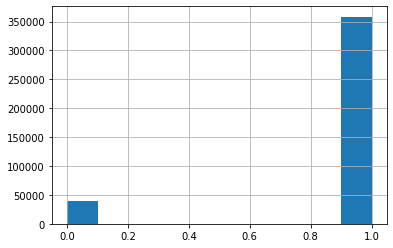

In [39]:
comprobacion['Success'].hist()

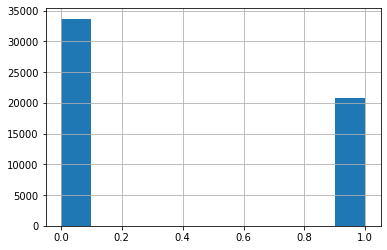

In [40]:
comprobacion[comprobacion['Count']>0]['Success'].hist()

In [41]:
comprobacion[comprobacion['Count']>0]['Success'].value_counts()

0    33674
1    20714
Name: Success, dtype: int64

In [42]:
(20708/(20708+33680))

0.3807457527395749

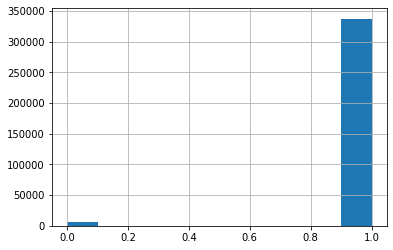

In [43]:
comprobacion[comprobacion['Count']==0]['Success'].hist()

In [44]:
comprobacion[comprobacion['Count']==0]['Success'].value_counts()

1    337647
0      5660
Name: Success, dtype: int64

In [45]:
(337668/(337668+5639))

0.9835744683330081

In [234]:
RANDOM_STATE=42
lista_x=[]
lista_strain=[]
lista_stest=[]
for i in range(10,100,20):
    xg_reg = xgb.XGBClassifier(colsample_bytree = 0.3, learning_rate = 0.05, alpha = 10, n_estimators = i, 
                                max_depth=8,random_state=RANDOM_STATE)
    xg_reg.fit(X_train,Y_train)
    score_train=xg_reg.score(X_train, Y_train)
    score_test=xg_reg.score(X_test, Y_test)
    print('n_stimators: {}. Train: {} - Test: {}'.format(i,score_train,score_test))
    lista_x.append(i)
    lista_strain.append(score_train)
    lista_stest.append(score_test)
score_df=pd.DataFrame(index=lista_x, data={'Score_train':lista_strain, 'Score_test':lista_stest})

[22:06:39] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\gbm\gbtree.cc:138: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
n_stimators: 10. Train: 0.8368454468876904 - Test: 0.8815981782521781
[22:08:08] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\gbm\gbtree.cc:138: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
n_stimators: 30. Train: 0.8581945649304115 - Test: 0.8835453362501414
[22:11:57] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\gbm\gbtree.cc:138: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
n_stimators: 50. Train: 0.8646288298821961 - Test: 0.882899

In [92]:
df.loc[ (df['Count-5']>0) ,'Count-5']=1

# Entrenamos el modelo

In [93]:
df["Periodo"].unique()

array(['2019-04-01T00:00:00.000000000', '2019-07-01T00:00:00.000000000',
       '2019-10-01T00:00:00.000000000', '2020-01-01T00:00:00.000000000',
       '2020-04-01T00:00:00.000000000', '2020-07-01T00:00:00.000000000',
       '2020-10-01T00:00:00.000000000'], dtype='datetime64[ns]')

In [94]:
# split the data into train, validation and test dataset
train_index = sorted(list(df["Periodo"].unique()))[:-1]

test_index = [sorted(list(df["Periodo"].unique()))[-1]]

In [95]:
train_index

[numpy.datetime64('2019-04-01T00:00:00.000000000'),
 numpy.datetime64('2019-07-01T00:00:00.000000000'),
 numpy.datetime64('2019-10-01T00:00:00.000000000'),
 numpy.datetime64('2020-01-01T00:00:00.000000000'),
 numpy.datetime64('2020-04-01T00:00:00.000000000'),
 numpy.datetime64('2020-07-01T00:00:00.000000000')]

In [96]:
test_index

[numpy.datetime64('2020-10-01T00:00:00.000000000')]

In [97]:
variables_borrar=['id',
'Periodo',
'Producto-Tipo',
'Count','MontoSignoSum','MontoSignoMean','MontoSignoMax','MontoSignoMin']

In [51]:
variables_borrar=['Periodo',
'Producto-Tipo']

In [98]:
X_train = df[df["Periodo"].isin(train_index)].drop(variables_borrar, axis=1)
Y_train = df[df["Periodo"].isin(train_index)]['Count']

#X_test = df[df["Periodo"].isin(test1_index)].drop(variables_borrar, axis = 1)
#Y_test = full_df[full_df["Periodo"].isin(test1_index)]['Count']

X_test = df[df["Periodo"].isin(test_index)].drop(variables_borrar, axis = 1)
Y_test = df[df["Periodo"].isin(test_index)]['Count']

In [99]:
dt = DecisionTreeClassifier(max_depth=12)

In [100]:
dt.fit(X_train,Y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=12, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [101]:
score_train=dt.score(X_train, Y_train)

In [102]:
score_train

0.8720914425627679

In [58]:
score_train

0.8713555614226983

In [103]:
y_test_pred = pd.DataFrame(dt.predict(X_test), index=Y_test.index, columns=['altaPrediction'])

In [192]:
#y_test_pred = pd.DataFrame(xg_reg.predict(X_test), index=Y_test.index, columns=['altaPrediction'])

In [104]:
results_df = Y_test.to_frame().join(y_test_pred)

In [105]:
results_df

,Count,altaPrediction
0,1.0,1.0
1,1.0,1.0
2,1.0,1.0
3,1.0,1.0
4,1.0,1.0
...,...,...
1272619,1.0,0.0
1272620,1.0,0.0
1272621,0.0,0.0
1272622,0.0,0.0


In [106]:
#X_test_head = df[['id','Periodo','Producto-Tipo','Count']][df["Periodo"].isin(test1_index)]
X_test_head = df[['id','Periodo','Producto-Tipo','Count']][df["Periodo"].isin(test_index)]

In [107]:
#X_test_head.drop('altaPrediction',axis=1,inplace=True)

In [108]:
X_test_head

,id,Periodo,Producto-Tipo,Count
0,1,2020-10-01,A-K,1.0
1,1,2020-10-01,F-D,1.0
2,1,2020-10-01,F-H,1.0
3,1,2020-10-01,F-J,1.0
4,1,2020-10-01,G-K,1.0
...,...,...,...,...
1272619,79539,2020-10-01,C-C,1.0
1272620,79539,2020-10-01,E-F,1.0
1272621,79539,2020-10-01,B-B,0.0
1272622,79539,2020-10-01,A-A,0.0


In [109]:
X_test_head = pd.concat([X_test_head,results_df['altaPrediction'].to_frame()],axis=1)

In [110]:
X_test_head

,id,Periodo,Producto-Tipo,Count,altaPrediction
0,1,2020-10-01,A-K,1.0,1.0
1,1,2020-10-01,F-D,1.0,1.0
2,1,2020-10-01,F-H,1.0,1.0
3,1,2020-10-01,F-J,1.0,1.0
4,1,2020-10-01,G-K,1.0,1.0
...,...,...,...,...,...
1272619,79539,2020-10-01,C-C,1.0,0.0
1272620,79539,2020-10-01,E-F,1.0,0.0
1272621,79539,2020-10-01,B-B,0.0,0.0
1272622,79539,2020-10-01,A-A,0.0,0.0


In [111]:
comprobacion=X_test_head[ (X_test_head['Producto-Tipo']=='A-A') |
              (X_test_head['Producto-Tipo']=='B-B') |
              (X_test_head['Producto-Tipo']=='C-D') |
              (X_test_head['Producto-Tipo']=='D-E') |
              (X_test_head['Producto-Tipo']=='E-E') ]

In [112]:
comprobacion

,id,Periodo,Producto-Tipo,Count,altaPrediction
8,1,2020-10-01,D-E,0.0,1.0
9,1,2020-10-01,C-D,0.0,0.0
10,1,2020-10-01,E-E,0.0,0.0
13,1,2020-10-01,B-B,0.0,0.0
14,1,2020-10-01,A-A,0.0,0.0
...,...,...,...,...,...
1272616,79539,2020-10-01,D-E,0.0,0.0
1272617,79539,2020-10-01,C-D,0.0,0.0
1272618,79539,2020-10-01,E-E,0.0,0.0
1272621,79539,2020-10-01,B-B,0.0,0.0


In [114]:
comprobacion['altaPrediction'].value_counts()

0.0    372458
1.0     25237
Name: altaPrediction, dtype: int64

In [115]:
comprobacion.loc[comprobacion['altaPrediction']>0,'Resultado']=comprobacion[comprobacion['altaPrediction']>0]['Producto-Tipo']

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [116]:
comprobacion 

,id,Periodo,Producto-Tipo,Count,altaPrediction,Resultado
8,1,2020-10-01,D-E,0.0,1.0,D-E
9,1,2020-10-01,C-D,0.0,0.0,NaN
10,1,2020-10-01,E-E,0.0,0.0,NaN
13,1,2020-10-01,B-B,0.0,0.0,NaN
14,1,2020-10-01,A-A,0.0,0.0,NaN
...,...,...,...,...,...,...
1272616,79539,2020-10-01,D-E,0.0,0.0,NaN
1272617,79539,2020-10-01,C-D,0.0,0.0,NaN
1272618,79539,2020-10-01,E-E,0.0,0.0,NaN
1272621,79539,2020-10-01,B-B,0.0,0.0,NaN


In [117]:
comprobacion[comprobacion['altaPrediction']>0]

,id,Periodo,Producto-Tipo,Count,altaPrediction,Resultado
8,1,2020-10-01,D-E,0.0,1.0,D-E
41,3,2020-10-01,C-D,0.0,1.0,C-D
42,3,2020-10-01,E-E,0.0,1.0,E-E
57,4,2020-10-01,C-D,0.0,1.0,C-D
58,4,2020-10-01,E-E,0.0,1.0,E-E
...,...,...,...,...,...,...
1272222,79514,2020-10-01,A-A,0.0,1.0,A-A
1272314,79520,2020-10-01,E-E,0.0,1.0,E-E
1272328,79521,2020-10-01,D-E,0.0,1.0,D-E
1272360,79523,2020-10-01,D-E,0.0,1.0,D-E


In [118]:
comprobacion.fillna('',inplace=True)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:4153: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


In [119]:
comprobacion 

,id,Periodo,Producto-Tipo,Count,altaPrediction,Resultado
8,1,2020-10-01,D-E,0.0,1.0,D-E
9,1,2020-10-01,C-D,0.0,0.0,
10,1,2020-10-01,E-E,0.0,0.0,
13,1,2020-10-01,B-B,0.0,0.0,
14,1,2020-10-01,A-A,0.0,0.0,
...,...,...,...,...,...,...
1272616,79539,2020-10-01,D-E,0.0,0.0,
1272617,79539,2020-10-01,C-D,0.0,0.0,
1272618,79539,2020-10-01,E-E,0.0,0.0,
1272621,79539,2020-10-01,B-B,0.0,0.0,


In [120]:
comprobacion[comprobacion['altaPrediction']>0]['Producto-Tipo'].value_counts()

D-E    11327
C-D     6682
E-E     3712
A-A     3403
B-B      113
Name: Producto-Tipo, dtype: int64

In [176]:
comprobacion[comprobacion['altaPrediction']>0]['Producto-Tipo'].value_counts()

D-E    56752
A-A    15145
C-D     6196
E-E     5397
B-B      110
Name: Producto-Tipo, dtype: int64

In [29]:
comprobacion[comprobacion['altaPrediction']>0]['Producto-Tipo'].value_counts()

D-E    59675
A-A    15244
C-D     4922
E-E     4468
Name: Producto-Tipo, dtype: int64

In [121]:
comprobacion_=comprobacion.groupby(['id','Periodo']).agg({'Resultado':np.sum})

In [122]:
comprobacion_

,,Resultado
id,Periodo,
1,2020-10-01,D-E
2,2020-10-01,
3,2020-10-01,C-DE-E
4,2020-10-01,C-DE-E
5,2020-10-01,
...,...,...
79535,2020-10-01,C-D
79536,2020-10-01,
79537,2020-10-01,


In [125]:
comprobacion_['Resultado'].value_counts()

                   58289
D-E                10119
C-D                 3652
A-A                 2630
C-D E-E             1955
E-E                 1175
D-E C-D              482
D-E A-A              310
D-E C-D E-E          214
C-D A-A              203
D-E E-E              141
C-D E-E A-A          122
B-B                   95
E-E A-A               79
D-E C-D A-A           32
D-E C-D E-E A-A       14
D-E E-E A-A            9
D-E B-B                6
C-DB-B                 5
B-BA-A                 4
C-DE-EB-B              3
Name: Resultado, dtype: int64

In [124]:
comprobacion_['Resultado'].replace('D-EA-A','D-E A-A',inplace=True)
comprobacion_['Resultado'].replace('D-EE-E','D-E E-E',inplace=True)
comprobacion_['Resultado'].replace('D-EE-EA-A','D-E E-E A-A',inplace=True)
comprobacion_['Resultado'].replace('E-EA-A','E-E A-A',inplace=True)
comprobacion_['Resultado'].replace('D-EC-DE-E','D-E C-D E-E',inplace=True)
comprobacion_['Resultado'].replace('C-DE-E','C-D E-E',inplace=True)
comprobacion_['Resultado'].replace('D-EC-D','D-E C-D',inplace=True)
comprobacion_['Resultado'].replace('D-EC-DE-EA-A','D-E C-D E-E A-A',inplace=True)
comprobacion_['Resultado'].replace('C-DE-EA-A','C-D E-E A-A',inplace=True)
comprobacion_['Resultado'].replace('D-EC-DA-A','D-E C-D A-A',inplace=True)
comprobacion_['Resultado'].replace('C-DA-A','C-D A-A',inplace=True)
comprobacion_['Resultado'].replace('D-EB-B','D-E B-B',inplace=True)

In [128]:
comprobacion_['Resultado'].replace('D-EB-BA-A','D-E B-B A-A',inplace=True)
comprobacion_['Resultado'].replace('B-BA-A','B-B A-A',inplace=True)
comprobacion_['Resultado'].replace('D-EE-EB-BA-A','D-E E-E B-B A-A',inplace=True)

In [126]:
comprobacion_['Resultado'].replace('C-DE-EB-B','C-D E-E B-B',inplace=True)
comprobacion_['Resultado'].replace('D-EE-EB-B','D-E E-E B-B',inplace=True)
comprobacion_['Resultado'].replace('D-EC-DE-EB-B','D-E C-D E-E B-B',inplace=True)
comprobacion_['Resultado'].replace('D-EC-DB-B','D-E C-D B-B',inplace=True)
comprobacion_['Resultado'].replace('D-EC-DE-EB-BA-A','D-E C-D E-E B-B A-A',inplace=True)
comprobacion_['Resultado'].replace('C-DE-EB-BA-A','C-D E-E B-B A-A',inplace=True)

In [130]:
comprobacion_['Resultado'].replace('C-DB-B','C-D B-B',inplace=True)

In [131]:
comprobacion_['Resultado'].value_counts()

                   58289
D-E                10119
C-D                 3652
A-A                 2630
C-D E-E             1955
E-E                 1175
D-E C-D              482
D-E A-A              310
D-E C-D E-E          214
C-D A-A              203
D-E E-E              141
C-D E-E A-A          122
B-B                   95
E-E A-A               79
D-E C-D A-A           32
D-E C-D E-E A-A       14
D-E E-E A-A            9
D-E B-B                6
C-D B-B                5
B-B A-A                4
C-D E-E B-B            3
Name: Resultado, dtype: int64

In [132]:
comprobacion_.reset_index(drop=False,inplace=True)

In [133]:
comprobacion_[['id','Resultado']].to_csv('prediccion-03122020.csv',index=False)

In [184]:
comprobacion_

,index,id,Periodo,Resultado
0,0,1,2020-10-01,
1,1,2,2020-10-01,A-A
2,2,3,2020-10-01,C-D E-E
3,3,4,2020-10-01,D-E C-D E-E
4,4,5,2020-10-01,D-E
...,...,...,...,...
79534,79534,79535,2020-10-01,D-E C-D
79535,79535,79536,2020-10-01,D-E
79536,79536,79537,2020-10-01,A-A
79537,79537,79538,2020-10-01,D-E


# Algoritmo de ensamble:

In [41]:
del df

In [42]:
gc.collect()

34164

In [43]:
RANDOM_STATE=42
lista_x=[]
lista_strain=[]
lista_stest=[]
for i in range(10,100,20):
    xg_reg = xgb.XGBClassifier(colsample_bytree = 0.3, learning_rate = 0.05, alpha = 10, n_estimators = i, 
                                max_depth=9,random_state=RANDOM_STATE)
    xg_reg.fit(X_train,Y_train)
    score_train=xg_reg.score(X_train, Y_train)
    print('n_stimators: {}. Train: {} '.format(i,score_train))
    lista_x.append(i)
    lista_strain.append(score_train)
score_df=pd.DataFrame(index=lista_x, data={'Score_train':lista_strain})

[19:29:46] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\gbm\gbtree.cc:138: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
n_stimators: 10. Train: 0.8409967646898586 
[19:31:01] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\gbm\gbtree.cc:138: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
n_stimators: 30. Train: 0.8570688069165231 
[19:34:23] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\gbm\gbtree.cc:138: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
n_stimators: 50. Train: 0.861806262755797 
[19:40:04] WARNING: C:\Users\Administrator\workspace\xgboost-win64_r

KeyboardInterrupt: 

In [44]:
# Vamos a pintar los resultados obtenidos para ver con que valor nos quedamos:
fig = go.Figure()
fig.update_layout(title_text='Relación de Score conn_stimators:')
fig.add_trace(go.Scatter(x=score_df.index,y=score_df['Score_train'], mode='lines+markers', name='Score_train'))
fig.add_trace(go.Scatter(x=score_df.index,y=score_df['Score_test'], mode='lines+markers', name='Score_test'))
fig.show()

NameError: name 'go' is not defined

In [74]:
xg_reg = xgb.XGBClassifier(colsample_bytree = 0.3, learning_rate = 0.05, alpha = 10, n_estimators = 30, 
                                max_depth=9,random_state=RANDOM_STATE)
xg_reg.fit(X_train,Y_train)

[20:03:00] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\gbm\gbtree.cc:138: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.


XGBClassifier(alpha=10, base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.3, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.05, max_delta_step=0, max_depth=9,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=30, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=42, reg_alpha=10,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)